<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw1/hw1_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement an autoregressive model and run it on two datasets (dataset 1 and dataset 2). The expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [1]:
# !if [ -d deepul ]; then rm -Rf deepul; fi
# !git clone https://github.com/rll/deepul.git 
# !unzip -qq deepul/homeworks/hw1/data/hw1_data.zip -d deepul/homeworks/hw1/data/
# !pip install ./deepul

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/home/magda/Github/deepul')
print(sys.path)

['/home/magda/Github/deepul/homeworks/hw1', '/home/magda/anaconda3/envs/pytorch/lib/python38.zip', '/home/magda/anaconda3/envs/pytorch/lib/python3.8', '/home/magda/anaconda3/envs/pytorch/lib/python3.8/lib-dynload', '', '/home/magda/anaconda3/envs/pytorch/lib/python3.8/site-packages', '/home/magda/anaconda3/envs/pytorch/lib/python3.8/site-packages/IPython/extensions', '/home/magda/.ipython', '/home/magda/Github/deepul']


In [4]:
from deepul.hw1_helper import *

# Question 2: MADE

In this question, you will implement [MADE](https://arxiv.org/abs/1502.03509). In the first part, you will use MADE to model a simple 2D joint distribution, and in the second half, you will train MADE on image datasets.

## Part (b) Shapes and MNIST
Now, we will work with a higher dimensional datasets, namely a shape dataset and MNIST. Run the cell below to visualize the two datasets

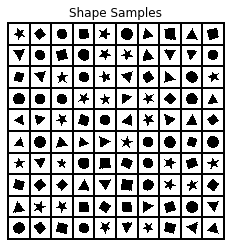

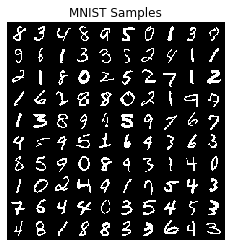

In [5]:
visualize_q2b_data(1)
visualize_q2b_data(2)

Implement and train a MADE model on the given binary image datasets. Given some binary image of height $H$ and width $W$, we can represent image $x\in \{0, 1\}^{H\times W}$ as a flattened binary vector $x\in \{0, 1\}^{HW}$ to input into MADE to model $p_\theta(x) = \prod_{i=1}^{HW} p_\theta(x_i|x_{<i})$. Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine).

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [6]:
from exp_utils import *
import math

class MaskedLinear(nn.Linear):
    def __init__(self, in_feat, out_feat, px_dim, prev_mk):
        super(MaskedLinear, self).__init__(in_feat, out_feat, bias=True)
        self.mask = nn.Parameter(torch.zeros(out_feat, in_feat), requires_grad=False)
#         self.mask = torch.zeros(out_feat, in_feat)
        prev_min = prev_mk.min().int()
        self.mk = torch.randint(prev_min, px_dim, (out_feat,))
        for outidx in range(out_feat):
            for inidx in range(in_feat):
                if self.mk[outidx] >= prev_mk[inidx]:
                    self.mask[outidx, inidx] = 1.
                
    def forward(self, x):
        return F.linear(x, self.weight * self.mask, self.bias)


class MaskedLinearOut(nn.Linear):
    def __init__(self, in_feat, out_feat, px_dim, prev_mk):
        super(MaskedLinearOut, self).__init__(in_feat, out_feat, bias=True)
        self.mask = nn.Parameter(torch.zeros(out_feat, in_feat), requires_grad=False)
#         self.mask = torch.zeros(out_feat, in_feat)
        self.mk = (torch.arange(px_dim)+1)
        for outidx in range(out_feat):
            for inidx in range(in_feat):
                if self.mk[outidx] > prev_mk[inidx]:
                    self.mask[outidx, inidx] = 1.
                
    def forward(self, x):
        return F.linear(x, self.weight * self.mask, self.bias)

class Made(nn.Module):
    def __init__(self, image_shape, hidden=[512, 512, 512]):
        super(Made, self).__init__()
        self.image_shape = image_shape
        self.px_dim = math.prod(image_shape)
        layers = []
        dims = [self.px_dim] + hidden
        prev_mk = (torch.arange(self.px_dim)+1)
        for idx in range(len(dims)-1):
            layers.append(MaskedLinear(dims[idx], dims[idx+1], self.px_dim, prev_mk))
            prev_mk = layers[-1].mk
            layers.append(nn.ReLU())
        layers.append(MaskedLinearOut(dims[-1], dims[0], self.px_dim, prev_mk))
        self.sequential = nn.Sequential(*layers)
        self.loss_func = nn.BCEWithLogitsLoss(reduction='none')
        
    def get_logits(self, x):
        logits = self.sequential(x.float())
        return logits
        
    def forward(self, x):
#         x = x.view(-1, self.px_dim).float()
        x = x.float()
        logits = self.get_logits(x)
        loss = self.loss_func(logits, x).sum(dim=1).mean(dim=0)
        return loss
    
    def sampling(self, size):
        print('begin sampling')
        self.eval()
        with torch.no_grad():
            sample = torch.ones(size, self.px_dim)
            if next(self.parameters()).is_cuda:
                sample = sample.cuda()
            for i in range(self.px_dim):
                logits = self.get_logits(sample)
                sample[:,i] = torch.bernoulli(torch.sigmoid(logits[:,i]))
            images = sample.view(-1, self.image_shape[0], self.image_shape[1], 1)
        return images
                

In [7]:
import math
def q2_b(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    test_data: An (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    image_shape: (H, W), height and width of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
    """

    """ YOUR CODE HERE """
    train_data = np.reshape(train_data, (-1, math.prod(image_shape)))
    test_data = np.reshape(test_data, (-1, math.prod(image_shape)))

    
    DEVICE = torch.device('cuda')
    train_loader, test_loader = get_loaders(train_data, test_data, bs=128)
    model = Made((image_shape), [512, 512]).to(DEVICE)
    adam_optim = torch.optim.Adam
    nll_train, nll_test = training(
        train_loader, test_loader,
        model, adam_optim, learn_rate=0.001, device=DEVICE, epochs=20)
#     breakpoint()
    return nll_train, nll_test, model.sampling(100).cpu().numpy()

### Results

Once you've implemented `q2_b`, execute the cells below to visualize and save your results



Epoch 0 train batch loss 1st: 277.080322265625 2nd: 274.53009033203125, last: 78.90274810791016
Epoch 1 train batch loss 1st: 76.81095123291016 2nd: 76.80587768554688, last: 61.847496032714844
Epoch 2 train batch loss 1st: 62.68989181518555 2nd: 63.79945373535156, last: 58.977848052978516
Epoch 3 train batch loss 1st: 54.155059814453125 2nd: 54.914649963378906, last: 47.781219482421875
Epoch 4 train batch loss 1st: 48.944000244140625 2nd: 48.46612548828125, last: 46.2287483215332
Epoch 5 train batch loss 1st: 47.608978271484375 2nd: 47.389625549316406, last: 40.83782958984375
Epoch 6 train batch loss 1st: 45.70537567138672 2nd: 42.199581146240234, last: 38.48487854003906
Epoch 7 train batch loss 1st: 40.94133758544922 2nd: 41.74989318847656, last: 37.57849884033203
Epoch 8 train batch loss 1st: 39.3671875 2nd: 38.745086669921875, last: 36.33030319213867
Epoch 9 train batch loss 1st: 36.05864715576172 2nd: 36.94927215576172, last: 34.62053298950195
Epoch 10 train batch loss 1st: 34.4690

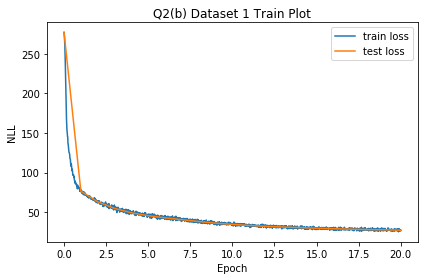

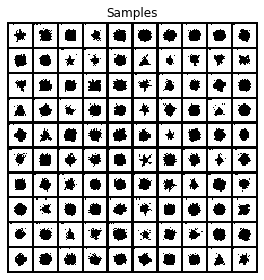

In [8]:
q2_save_results(1, 'b', q2_b)

Epoch 0 train batch loss 1st: 543.550048828125 2nd: 541.5263671875, last: 156.52957153320312
Epoch 1 train batch loss 1st: 159.11326599121094 2nd: 160.50003051757812, last: 129.16943359375
Epoch 2 train batch loss 1st: 124.82026672363281 2nd: 125.38554382324219, last: 117.18424987792969
Epoch 3 train batch loss 1st: 116.07667541503906 2nd: 111.16040802001953, last: 105.020263671875
Epoch 4 train batch loss 1st: 104.80918884277344 2nd: 105.65609741210938, last: 102.82414245605469
Epoch 5 train batch loss 1st: 102.75518798828125 2nd: 106.22764587402344, last: 98.22146606445312
Epoch 6 train batch loss 1st: 99.66242218017578 2nd: 99.96647644042969, last: 95.65850830078125
Epoch 7 train batch loss 1st: 103.36571502685547 2nd: 101.20529174804688, last: 97.22017669677734
Epoch 8 train batch loss 1st: 98.0230941772461 2nd: 94.19186401367188, last: 98.18730926513672
Epoch 9 train batch loss 1st: 93.64641571044922 2nd: 94.47370910644531, last: 88.95919036865234
Epoch 10 train batch loss 1st: 88

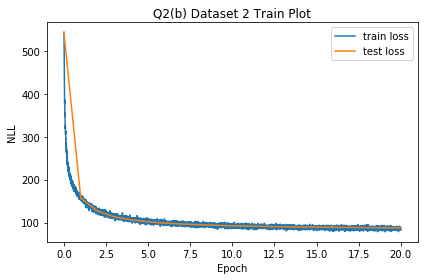

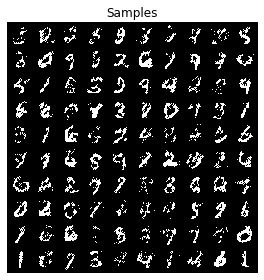

In [9]:
q2_save_results(2, 'b', q2_b)